# Classificação utilizando somente imagens

In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf

from nltk.stem.porter import PorterStemmer

import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

import yaml

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers, callbacks
from keras.utils.layer_utils import count_params

from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

In [3]:
with open("../../config.yaml", "r") as stream:
    try:
        configs = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [4]:
PATH_TO_TRAIN_DS_PROCESSED = str(configs['ROOT_DIR'] + configs['PATH_TO_TRAIN_DS_PROCESSED'])
PATH_TO_WEIGHTS            = str(configs['ROOT_DIR'] + configs['PATH_TO_WEIGHTS'])
PATH_TO_IMAGES             = str(configs['ROOT_DIR'] + configs['PATH_TO_IMAGES'])

## Leitura da base de dados

In [5]:
df_train_cleaned = pd.read_csv(PATH_TO_TRAIN_DS_PROCESSED)
df_train_cleaned.head()

,image_name,text,humour,sarcasm,offensive,motivational,target
0,image_1415.jpeg,if you want to view paradis simpli look around...,not_funny,not_sarcastic,not_offensive,motivational,positive
1,image_6460.png,if i had a brick for everi lie hillari told i ...,hilarious,general,very_offensive,motivational,positive
2,image_2303.png,that thing over there can i eat that,very_funny,general,not_offensive,motivational,very_positive
3,image_2417.png,my dad point to liam and said when did david b...,not_funny,general,very_offensive,motivational,neutral
4,image_11.jpg,probabl the first man to do year challeng chen...,funny,general,very_offensive,motivational,negative


In [11]:
df_train_cleaned.replace("very_positive", 
           "positive", 
           inplace=True)
df_train_cleaned.replace("very_negative", 
           "negative", 
           inplace=True)       
df_train_cleaned.head()

,image_name,humour,sarcasm,offensive,motivational,label,text_corrected_cleaned_stemmed
0,image_1415.jpeg,not_funny,not_sarcastic,not_offensive,motivational,positive,if you want to view paradis simpli look around...
1,image_6460.png,hilarious,general,very_offensive,motivational,positive,if i had a brick for everi lie hillari told i ...
2,image_2303.png,very_funny,general,not_offensive,motivational,positive,that thing over there can i eat that
3,image_2417.png,not_funny,general,very_offensive,motivational,neutral,my dad point to liam and said when did david b...
4,image_11.jpg,funny,general,very_offensive,motivational,negative,probabl the first man to do year challeng chen...


C:\Users\Vitor\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Frequencia das classes no conjunto de treinamento pré-divisão (5453 amostras)'}>

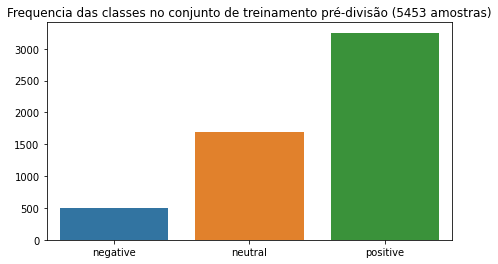

In [12]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento pré-divisão (%i amostras)' % len(df_train_cleaned))
labels, counts = np.unique(df_train_cleaned['target'], return_counts=True)
sns.barplot(labels, counts)

### Divisão do conjunto de dados (treino/validação)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 356.97it/s]
C:\Users\Vitor\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Vitor\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Vitor\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument wil

<AxesSubplot:title={'center':'Frequencia das classes no conjunto de validação (1090 amostras)'}>

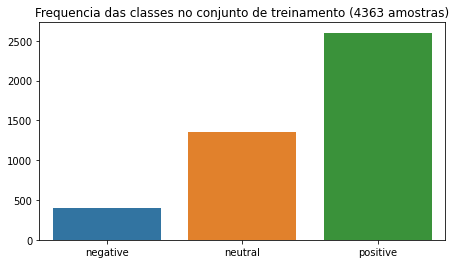

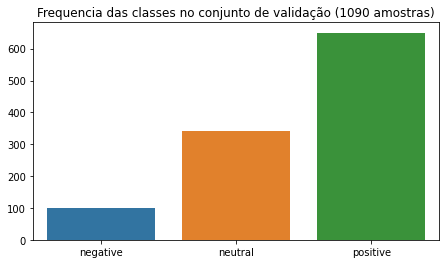

In [13]:
train_frac = 0.8
id_col = 'image_name'
df_train_val = get_train_val_split(train_frac, df_train_cleaned, id_col)

le = LabelEncoder()
df_train_val['label_encoder'] = le.fit_transform(df_train_val[['target']])

df_sep_train = df_train_val[df_train_val.split=='train'].drop(columns='split')
df_sep_val = df_train_val[df_train_val.split=='val'].drop(columns='split')

plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(df_sep_train))
labels, counts = np.unique(df_sep_train['target'], return_counts=True)
sns.barplot(labels, counts)

plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.title('Frequencia das classes no conjunto de validação (%i amostras)' % len(df_sep_val))
labels, counts = np.unique(df_sep_val['target'], return_counts=True)
sns.barplot(labels, counts)

### Cálculo dos pesos das classes

In [14]:
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(df_sep_train['target']), 
                                     y=df_sep_train['target']
                                    )
train_class_weights = dict(enumerate(class_weights))

for i, label in enumerate(np.unique(df_sep_train['target'])):
    print('Class: '+label+'\t| Weight: '+str(class_weights[i]))

Class: negative	| Weight: 3.6177446102819237
Class: neutral	| Weight: 1.0693627450980392
Class: positive	| Weight: 0.5591439190055107


### Carregando imagens

In [15]:
#Carregando imagens do treino
width = 100
height = 100
X_train = []
X_train_path = []
for i in tqdm(df_sep_train['image_name']):
    path = PATH_TO_IMAGES + i
    img = image.load_img(path,target_size=(width,height,3))
    img = image.img_to_array(img)
    # img = img/255.0
    X_train.append(img)
    X_train_path.append(path)

#Carregando imagens da validação
X_val = []
X_val_path = []
for i in tqdm(df_sep_val['image_name']):
    path = PATH_TO_IMAGES + i
    img = image.load_img(path,target_size=(width,height,3))
    img = image.img_to_array(img)
    # img = img/255.0
    X_val.append(img)
    X_val_path.append(path)

 65%|███████████████████████████████████████████████████████████▏                               | 2840/4363 [00:09<00:04, 314.91it/s]C:\Users\Vitor\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████| 1090/1090 [00:04<00:00, 250.19it/s]


In [16]:
#Algumas transformações
X_train = np.array(X_train)
X_val = np.array(X_val)
Y_train = df_sep_train.iloc[:,-1].astype('category')
Y_train_code = Y_train.cat.codes
Y_val = df_sep_val.iloc[:,-1].astype('category')
Y_val_code=Y_val.cat.codes
n_classes=len(np.unique(df_sep_train['target']))
Y_train = tf.keras.utils.to_categorical(Y_train, n_classes)
Y_val = tf.keras.utils.to_categorical(Y_val, n_classes)

#Criando o gerador para as transformações
#Aqui, após alguns testes, encontrei que as melhores aumentações são a mudança de brilho e mudanças nos canais da imagem.
#Faz sentido pq elas não descaracterizam o meme.
datagen_image = ImageDataGenerator(brightness_range=[0.7,1.5],preprocessing_function=tf.keras.applications.resnet50.preprocess_input,channel_shift_range=20)

train_batches = datagen_image.flow(X_train, np.array(Y_train), shuffle=False, batch_size=64)
val_batches = datagen_image.flow(X_val, np.array(Y_val), shuffle=False, batch_size=64)

## Treinamento e Avaliação

In [18]:
def define_frozen_network(originalNN, numTrainableLayers, numClasses):
    # Congela camadas pré-treinadas menos últimas 4 que serão feitas o fine tunning
    for layer in originalNN.layers[:-numTrainableLayers]:
        layer.trainable = False

    # Inclui camada de avg pooling e densa no final
    newNN = tf.keras.Sequential([originalNN,
                                 layers.GlobalAveragePooling2D(),
                                 layers.Dense(numClasses, activation='softmax')
                                ])

    # Compila modelo com otimizador sgd
    sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=0.001)
    newNN.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                 )
    print('Numero de parametros treinaveis: '+str(count_params(newNN.trainable_weights)))
    
    return newNN

#### ResNet50

In [128]:
tf.keras.backend.clear_session()
early =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Carregamento do modelo pré-treinado sem as camadas densas
model_ResNet50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(width,height,3))
# Cria modelo para posterior fine tunning
model_ResNet50_frozen = define_frozen_network(model_ResNet50, 4, n_classes)

# Treina modelo
model_ResNet50_frozen.fit(train_batches, 
                          epochs=500, 
                          class_weight=train_class_weights,
                          validation_data=val_batches,
                          callbacks=[early]
                         )

Numero de parametros treinaveis: 1060867
Epoch 1/500
69/69 [==============================] - 55s 770ms/step - loss: 4.4350 - accuracy: 0.3094 - val_loss: 3.8075 - val_accuracy: 0.5945
Epoch 2/500
69/69 [==============================] - 53s 767ms/step - loss: 4.8868 - accuracy: 0.3165 - val_loss: 1.6494 - val_accuracy: 0.5560
Epoch 3/500
69/69 [==============================] - 53s 763ms/step - loss: 3.0178 - accuracy: 0.3486 - val_loss: 1.4420 - val_accuracy: 0.3394
Epoch 4/500
69/69 [==============================] - 53s 764ms/step - loss: 2.9974 - accuracy: 0.3424 - val_loss: 2.8335 - val_accuracy: 0.2523
Epoch 5/500
69/69 [==============================] - 53s 764ms/step - loss: 3.4146 - accuracy: 0.3333 - val_loss: 1.4050 - val_accuracy: 0.5679
Epoch 6/500
69/69 [==============================] - 53s 769ms/step - loss: 2.4622 - accuracy: 0.2925 - val_loss: 1.1993 - val_accuracy: 0.5688
Epoch 7/500
69/69 [==============================] - 53s 763ms/step - loss: 2.4411 - accuracy: 

In [129]:
# Predicao no conjunto de validacao
y_val_pred = model_ResNet50_frozen.predict(val_batches)

# Metricas
print('F1 score = '+str(f1_score(val_batches.y.argmax(axis=-1),y_val_pred.argmax(axis=-1),average='macro')))
print('Balanced accuracy = '+str(balanced_accuracy_score(val_batches.y.argmax(axis=-1),y_val_pred.argmax(axis=-1))))
print('Relative confusion matrix:')
print(confusion_matrix(val_batches.y.argmax(axis=-1),y_val_pred.argmax(axis=-1),normalize='true'))

# Salva modelo
model_ResNet50_frozen.save(PATH_TO_WEIGHTS + 'ResNet50_frozen.h5')

18/18 [==============================] - 13s 658ms/step
F1 score = 0.3176373743259617
Balanced accuracy = 0.33648567119155354
Relative confusion matrix:
[[0.         0.22       0.78      ]
 [0.         0.26176471 0.73823529]
 [0.         0.25230769 0.74769231]]


#### ResNet152

In [130]:
tf.keras.backend.clear_session()
early =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Carregamento do modelo pré-treinado sem as camadas densas
model_ResNet152 = tf.keras.applications.resnet.ResNet152(weights='imagenet', include_top=False, input_shape=(width,height,3))
# Cria modelo para posterior fine tunning
model_ResNet152_frozen = define_frozen_network(model_ResNet152, 4, n_classes)

# Treina modelo
model_ResNet152_frozen.fit(train_batches, 
                           epochs=500, 
                           class_weight=train_class_weights,
                           validation_data=val_batches,
                           callbacks=[early]
                          )

Numero de parametros treinaveis: 1060867
Epoch 1/500
69/69 [==============================] - 147s 2s/step - loss: 5.1783 - accuracy: 0.3456 - val_loss: 16.0660 - val_accuracy: 0.0917
Epoch 2/500
69/69 [==============================] - 133s 2s/step - loss: 4.2593 - accuracy: 0.3931 - val_loss: 8.4782 - val_accuracy: 0.5963
Epoch 3/500
69/69 [==============================] - 134s 2s/step - loss: 5.8203 - accuracy: 0.3919 - val_loss: 4.7321 - val_accuracy: 0.5963
Epoch 4/500
69/69 [==============================] - 133s 2s/step - loss: 6.5642 - accuracy: 0.3440 - val_loss: 7.6716 - val_accuracy: 0.1174
Epoch 5/500
69/69 [==============================] - 134s 2s/step - loss: 6.1901 - accuracy: 0.3564 - val_loss: 1.5360 - val_accuracy: 0.3963
Epoch 6/500
69/69 [==============================] - 133s 2s/step - loss: 3.2660 - accuracy: 0.4864 - val_loss: 8.8434 - val_accuracy: 0.0972
Epoch 7/500
69/69 [==============================] - 133s 2s/step - loss: 4.3948 - accuracy: 0.3190 - val_

In [131]:
# Predicao no conjunto de validacao
y_val_pred = model_ResNet152_frozen.predict(val_batches)

# Metricas
print('F1 score = '+str(f1_score(val_batches.y.argmax(axis=-1),y_val_pred.argmax(axis=-1),average='macro')))
print('Balanced accuracy = '+str(balanced_accuracy_score(val_batches.y.argmax(axis=-1),y_val_pred.argmax(axis=-1))))
print('Relative confusion matrix:')
print(confusion_matrix(val_batches.y.argmax(axis=-1),y_val_pred.argmax(axis=-1),normalize='true'))

# Salva modelo
model_ResNet152_frozen.save(PATH_TO_WEIGHTS + 'ResNet152_frozen.h5')

18/18 [==============================] - 26s 1s/step
F1 score = 0.28043826716922216
Balanced accuracy = 0.3159728506787331
Relative confusion matrix:
[[0.03       0.53       0.44      ]
 [0.00294118 0.61176471 0.38529412]
 [0.00461538 0.68923077 0.30615385]]


#### InceptionV3

In [107]:
tf.keras.backend.clear_session()
early =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Carregamento do modelo pré-treinado sem as camadas densas
model_InceptionV3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(width,height,3))
# Cria modelo para posterior fine tunning
model_InceptionV3_frozen = define_frozen_network(model_InceptionV3, 4, n_classes)

# Treina modelo
model_InceptionV3_frozen.fit(train_batches, 
                             epochs=500, 
                             class_weight=train_class_weights,
                             validation_data=val_batches,
                             callbacks=[early]
                            )

87910968/87910968 [==============================] - 13s 0us/step
Numero de parametros treinaveis: 6147
Epoch 1/500
69/69 [==============================] - 21s 274ms/step - loss: 4484.1797 - accuracy: 0.4398 - val_loss: 15044.8115 - val_accuracy: 0.3119
Epoch 2/500
69/69 [==============================] - 19s 281ms/step - loss: 5347.6816 - accuracy: 0.2741 - val_loss: 8648.7920 - val_accuracy: 0.0917
Epoch 3/500
69/69 [==============================] - 19s 279ms/step - loss: 4621.1626 - accuracy: 0.3401 - val_loss: 1052.9166 - val_accuracy: 0.1394
Epoch 4/500
69/69 [==============================] - 20s 284ms/step - loss: 4101.3296 - accuracy: 0.2879 - val_loss: 911.6999 - val_accuracy: 0.5945
Epoch 5/500
69/69 [==============================] - 20s 295ms/step - loss: 5550.9326 - accuracy: 0.3463 - val_loss: 1103.6455 - val_accuracy: 0.3193
Epoch 6/500
69/69 [==============================] - 20s 294ms/step - loss: 5295.9551 - accuracy: 0.3440 - val_loss: 1908.8781 - val_accuracy: 0.5

In [123]:
# Predicao no conjunto de validacao
y_val_pred = model_InceptionV3_frozen.predict(val_batches)

# Metricas
print('F1 score = '+str(f1_score(val_batches.y.argmax(axis=-1),y_val_pred.argmax(axis=-1),average='macro')))
print('Balanced accuracy = '+str(balanced_accuracy_score(val_batches.y.argmax(axis=-1),y_val_pred.argmax(axis=-1))))
print('Relative confusion matrix:')
print(confusion_matrix(val_batches.y.argmax(axis=-1),y_val_pred.argmax(axis=-1),normalize='true'))

# Salva modelo
model_InceptionV3_frozen.save(PATH_TO_WEIGHTS + 'InceptionV3_frozen.h5')

18/18 [==============================] - 4s 200ms/step
F1 score = 0.24918535556833432
Balanced accuracy = 0.3333333333333333
Relative confusion matrix:
[[0.         0.         1.        ]
 [0.00294118 0.         0.99705882]
 [0.         0.         1.        ]]


#### VGG16

In [113]:
tf.keras.backend.clear_session()
early =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Carregamento do modelo pré-treinado sem as camadas densas
model_VGG16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(width,height,3))
# Cria modelo para posterior fine tunning
model_VGG16_frozen = define_frozen_network(model_VGG16, 2, n_classes)

# Treina modelo
model_VGG16_frozen.fit(train_batches,
                       epochs=500, 
                       class_weight=train_class_weights,
                       validation_data=val_batches,
                       callbacks=[early]
                      )

Numero de parametros treinaveis: 2361347
Epoch 1/500
69/69 [==============================] - 56s 807ms/step - loss: 7.1670 - accuracy: 0.2329 - val_loss: 1.1037 - val_accuracy: 0.4596
Epoch 2/500
69/69 [==============================] - 55s 803ms/step - loss: 1.0694 - accuracy: 0.3780 - val_loss: 1.1307 - val_accuracy: 0.2505
Epoch 3/500
69/69 [==============================] - 54s 788ms/step - loss: 1.0222 - accuracy: 0.5072 - val_loss: 1.1182 - val_accuracy: 0.4321
Epoch 4/500
69/69 [==============================] - 55s 796ms/step - loss: 1.0428 - accuracy: 0.5042 - val_loss: 1.1118 - val_accuracy: 0.4367
Epoch 5/500
69/69 [==============================] - 56s 808ms/step - loss: 0.9493 - accuracy: 0.4566 - val_loss: 1.1216 - val_accuracy: 0.4266
Epoch 6/500
69/69 [==============================] - 55s 794ms/step - loss: 1.0498 - accuracy: 0.5267 - val_loss: 1.1120 - val_accuracy: 0.5138
Epoch 7/500
69/69 [==============================] - 57s 824ms/step - loss: 1.0141 - accuracy: 

In [124]:
# Predicao no conjunto de validacao
y_val_pred = model_VGG16_frozen.predict(val_batches)

# Metricas
print('F1 score = '+str(f1_score(val_batches.y.argmax(axis=-1),y_val_pred.argmax(axis=-1),average='macro')))
print('Balanced accuracy = '+str(balanced_accuracy_score(val_batches.y.argmax(axis=-1),y_val_pred.argmax(axis=-1))))
print('Relative confusion matrix:')
print(confusion_matrix(val_batches.y.argmax(axis=-1),y_val_pred.argmax(axis=-1),normalize='true'))

model_VGG16_frozen.save(PATH_TO_WEIGHTS + 'VGG16_frozen.h5')

18/18 [==============================] - 19s 1s/step
F1 score = 0.3290318686404194
Balanced accuracy = 0.33057315233785817
Relative confusion matrix:
[[0.06       0.35       0.59      ]
 [0.06764706 0.27941176 0.65294118]
 [0.03538462 0.31230769 0.65230769]]


#### VGG19

In [115]:
tf.keras.backend.clear_session()
early =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Carregamento do modelo pré-treinado sem as camadas densas
model_VGG19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(width,height,3))
# Cria modelo para posterior fine tunning
model_VGG19_frozen = define_frozen_network(model_VGG19, 2, n_classes)

# Treina modelo
model_VGG19_frozen.fit(train_batches,
                       epochs=500, 
                       class_weight=train_class_weights,
                       validation_data=val_batches,
                       callbacks=[early]
                      )

80134624/80134624 [==============================] - 10s 0us/step
Numero de parametros treinaveis: 2361347
Epoch 1/500
69/69 [==============================] - 68s 976ms/step - loss: 12.6872 - accuracy: 0.2661 - val_loss: 1.1306 - val_accuracy: 0.1725
Epoch 2/500
69/69 [==============================] - 69s 997ms/step - loss: 1.0684 - accuracy: 0.3514 - val_loss: 1.1441 - val_accuracy: 0.1853
Epoch 3/500
69/69 [==============================] - 69s 1s/step - loss: 1.0316 - accuracy: 0.2815 - val_loss: 1.1133 - val_accuracy: 0.2633
Epoch 4/500
69/69 [==============================] - 71s 1s/step - loss: 1.0301 - accuracy: 0.4994 - val_loss: 1.1034 - val_accuracy: 0.4661
Epoch 5/500
69/69 [==============================] - 68s 986ms/step - loss: 0.9979 - accuracy: 0.4288 - val_loss: 1.0889 - val_accuracy: 0.4991
Epoch 6/500
69/69 [==============================] - 69s 999ms/step - loss: 0.9792 - accuracy: 0.5501 - val_loss: 1.1326 - val_accuracy: 0.4128
Epoch 7/500
69/69 [===============

In [125]:
# Predicao no conjunto de validacao
y_val_pred = model_VGG19_frozen.predict(val_batches)

# Metricas
print('F1 score = '+str(f1_score(val_batches.y.argmax(axis=-1),y_val_pred.argmax(axis=-1),average='macro')))
print('Balanced accuracy = '+str(balanced_accuracy_score(val_batches.y.argmax(axis=-1),y_val_pred.argmax(axis=-1))))
print('Relative confusion matrix:')
print(confusion_matrix(val_batches.y.argmax(axis=-1),y_val_pred.argmax(axis=-1),normalize='true'))

model_VGG19_frozen.save(PATH_TO_WEIGHTS + 'VGG19_frozen.h5')

18/18 [==============================] - 23s 1s/step
F1 score = 0.3091620032937992
Balanced accuracy = 0.31576168929110104
Relative confusion matrix:
[[0.02       0.28       0.7       ]
 [0.09117647 0.20882353 0.7       ]
 [0.08615385 0.19538462 0.71846154]]


#### EfficientNetV2B0

In [26]:
tf.keras.backend.clear_session()
early =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Carregamento do modelo pré-treinado sem as camadas densas
model_EfficientNetV2B0 = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(width,height,3))
# Cria modelo para posterior fine tunning
model_EfficientNetV2B0_frozen = define_frozen_network(model_EfficientNetV2B0, 4, n_classes)

# Treina modelo
model_EfficientNetV2B0_frozen.fit(train_batches,
                                  epochs=500, 
                                  class_weight=train_class_weights,
                                  validation_data=val_batches,
                                  callbacks=[early]
                                 )

Numero de parametros treinaveis: 252163
Epoch 1/500
69/69 [==============================] - 22s 264ms/step - loss: 1.2141 - accuracy: 0.2812 - val_loss: 1.1164 - val_accuracy: 0.3193
Epoch 2/500
69/69 [==============================] - 17s 244ms/step - loss: 1.2018 - accuracy: 0.2948 - val_loss: 1.1246 - val_accuracy: 0.3009
Epoch 3/500
69/69 [==============================] - 16s 238ms/step - loss: 1.1684 - accuracy: 0.2659 - val_loss: 1.1351 - val_accuracy: 0.3018
Epoch 4/500
69/69 [==============================] - 17s 241ms/step - loss: 1.1530 - accuracy: 0.3035 - val_loss: 1.1921 - val_accuracy: 0.2908
Epoch 5/500
69/69 [==============================] - 17s 245ms/step - loss: 1.1458 - accuracy: 0.2569 - val_loss: 1.1472 - val_accuracy: 0.2927
Epoch 6/500
69/69 [==============================] - 17s 241ms/step - loss: 1.1337 - accuracy: 0.2732 - val_loss: 1.1247 - val_accuracy: 0.2853
Epoch 7/500
69/69 [==============================] - 16s 237ms/step - loss: 1.1345 - accuracy: 0

In [27]:
# Predicao no conjunto de validacao
y_val_pred = model_EfficientNetV2B0_frozen.predict(val_batches)

# Metricas
print('F1 score = '+str(f1_score(val_batches.y.argmax(axis=-1),y_val_pred.argmax(axis=-1),average='macro')))
print('Balanced accuracy = '+str(balanced_accuracy_score(val_batches.y.argmax(axis=-1),y_val_pred.argmax(axis=-1))))
print('Relative confusion matrix:')
print(confusion_matrix(val_batches.y.argmax(axis=-1),y_val_pred.argmax(axis=-1),normalize='true'))

model_EfficientNetV2B0_frozen.save(PATH_TO_WEIGHTS + 'EfficientNetV2B0_frozen.h5')

18/18 [==============================] - 4s 182ms/step
F1 score = 0.2987120869172089
Balanced accuracy = 0.3540874811463047
Relative confusion matrix:
[[0.44       0.21       0.35      ]
 [0.38529412 0.31764706 0.29705882]
 [0.41846154 0.27692308 0.30461538]]


#### EfficientNetV2M

In [119]:
tf.keras.backend.clear_session()
early =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Carregamento do modelo pré-treinado sem as camadas densas
model_EfficientNetV2M = tf.keras.applications.EfficientNetV2M(weights='imagenet', include_top=False, input_shape=(width,height,3))
# Cria modelo para posterior fine tunning
model_EfficientNetV2M_frozen = define_frozen_network(model_EfficientNetV2M, 4, n_classes)

# Treina modelo
model_EfficientNetV2M_frozen.fit(train_batches,
                                 epochs=500, 
                                 class_weight=train_class_weights,
                                 validation_data=val_batches,
                                 callbacks=[early]
                                )

214201816/214201816 [==============================] - 33s 0us/step
Numero de parametros treinaveis: 661763
Epoch 1/500
69/69 [==============================] - 104s 1s/step - loss: 1.1633 - accuracy: 0.3216 - val_loss: 1.1177 - val_accuracy: 0.3596
Epoch 2/500
69/69 [==============================] - 89s 1s/step - loss: 1.1624 - accuracy: 0.3397 - val_loss: 1.1747 - val_accuracy: 0.2679
Epoch 3/500
69/69 [==============================] - 91s 1s/step - loss: 1.1360 - accuracy: 0.2993 - val_loss: 1.1035 - val_accuracy: 0.3688
Epoch 4/500
69/69 [==============================] - 93s 1s/step - loss: 1.1422 - accuracy: 0.2821 - val_loss: 1.0856 - val_accuracy: 0.3789
Epoch 5/500
69/69 [==============================] - 94s 1s/step - loss: 1.1534 - accuracy: 0.3076 - val_loss: 1.0826 - val_accuracy: 0.3761
Epoch 6/500
69/69 [==============================] - 92s 1s/step - loss: 1.1377 - accuracy: 0.3365 - val_loss: 1.1318 - val_accuracy: 0.3028
Epoch 7/500
69/69 [==========================

In [127]:
# Predicao no conjunto de validacao
y_val_pred = model_EfficientNetV2M_frozen.predict(val_batches)

# Metricas
print('F1 score = '+str(f1_score(val_batches.y.argmax(axis=-1),y_val_pred.argmax(axis=-1),average='macro')))
print('Balanced accuracy = '+str(balanced_accuracy_score(val_batches.y.argmax(axis=-1),y_val_pred.argmax(axis=-1))))
print('Relative confusion matrix:')
print(confusion_matrix(val_batches.y.argmax(axis=-1),y_val_pred.argmax(axis=-1),normalize='true'))

model_EfficientNetV2M_frozen.save(PATH_TO_WEIGHTS + 'EfficientNetV2M_frozen.h5')

18/18 [==============================] - 19s 1s/step
F1 score = 0.30587029068635646
Balanced accuracy = 0.31874811463046754
Relative confusion matrix:
[[0.22       0.4        0.38      ]
 [0.25294118 0.31470588 0.43235294]
 [0.23846154 0.34       0.42153846]]


## Compilação dos resultados

Em termos de acurácia normalizada, as melhores arquiteturas foram:
1. EfficientNetV2B0 = 34.63%
2. ResNet50 = 33.65%
3. InceptionV3 = 33.33%
4. VGG16 = 33.06%
5. EfficientNetV2M = 31.87%
6. ResNet152 = 31.60%
7. VGG19 = 31.58%

No geral, nenhuma das redes cons